In [137]:
import os, re
from dotenv import dotenv_values

from sqlalchemy import create_engine, text

from datetime import date,datetime,timedelta
import pandas as pd
import numpy as np

from tensorflow import keras

from matplotlib import pyplot as plt

import requests

## API and SQL configuration

In [29]:
# Settings from .env file

settings = dotenv_values()

# SQL CONFIG

settings = dotenv_values() # Loads settings from .env file
ROOT='..' # relative path to the root of the project

db_uri = (
    f"mysql+pymysql://{settings['SQL_USER']}:{settings['SQL_PWD']}"
    f"@{settings['SQL_HOST']}/{settings['SQL_DB']}"
    f"?ssl_ca={os.path.join(ROOT,settings['SQL_SSL_CA'])}"
    f"&ssl_cert={os.path.join(ROOT,settings['SQL_SSL_CERT'])}"
    f"&ssl_key={os.path.join(ROOT,settings['SQL_SSL_KEY'])}"
    f"&ssl_check_hostname=false"
)

engine = create_engine(db_uri,echo=False, future=False)

# WeatherAPI CONFIG

url = 'http://api.weatherapi.com/v1/forecast.json'
key = settings['WA_KEY']

## Test configuration (dates, station_id)

In [8]:
# Test Station ID
station_id = 6000990

# list of the 60 days before today (for History data)
history_days = pd.date_range(date.today() - timedelta(60),periods=60)

# list of today + 9 following days (for Forecast data)
forecast_days = pd.date_range(date.today(),periods=10)
forecast_days

# all days
days = pd.date_range(date.today() - timedelta(60),periods=70)

## Data Loading (Weather History an Forecast, Station info)

In [12]:
# station dataframe (from Cloud SQL)

query = "SELECT * FROM stations ;"
stations = pd.read_sql_query(query,engine)
stations.set_index('station_id',inplace=True,drop=True)
stations.head()

,label,alt,river_id,river_label,mean_nitrate,lat,lon
station_id,,,,,,,
6000990,BELRUPT,292,U---0000,La Saône,4.513699,48.090273,6.101941
6000993,JONVELLE,230,U---0000,La Saône,9.433333,47.936380,5.923536
6000998,MONTHUREUX-SUR-SAONE 2,241,U---0000,La Saône,6.428571,48.018251,5.941492
6001000,CENDRECOURT,213,U---0000,La Saône,9.233333,47.840261,5.917378
6002500,PORT-SUR-SAONE,208,U---0000,La Saône,7.489474,47.691078,6.039292


In [78]:
# Weather History dataframe (weather history, from Cloud SQL)

query = """
SELECT day, station_id, temperature, precipitation, maxwind
FROM weather
WHERE station_id = {}
AND day BETWEEN '{}' AND '{}' ;
"""

# We can use str.format() here, injection safe, pd.read_sql_query() used
f_query = query.format(
    station_id,
    history_days[0].strftime('%Y-%m-%d'),
    history_days[-1].strftime('%Y-%m-%d')
)

history_weather = pd.read_sql_query(f_query,engine)
history_weather.day = pd.to_datetime(history_weather.day)
history_weather.head()


,day,station_id,temperature,precipitation,maxwind
0,2021-12-13,6000990,3.7,0.0,4.3
1,2021-12-14,6000990,5.1,0.0,4.3
2,2021-12-15,6000990,4.6,0.0,5.8
3,2021-12-16,6000990,4.7,0.0,10.8
4,2021-12-17,6000990,3.7,0.0,10.8


In [94]:
# Weather Forecast dataframe (weather forecast, from WeatherAPI.com API)

gps_coord = f"{stations.loc[station_id,'lat']},{stations.loc[station_id,'lon']}"

params = {
    'key':key,
    'q':gps_coord,
    'days':10,
}

response = requests.get(url,params)
json_resp = response.json()
forecast_days = json_resp.get('forecast').get('forecastday')

# Tests
assert response                                                               # response in 2XX and 3XX
assert len(forecast_days) == 10                                               # 10 days in the response
assert forecast_days[0].get('date') == datetime.today().strftime('%Y-%m-%d')  # First day is today


list_forecast = {
    'day':[],
    'temperature':[],
    'precipitation':[],
    'maxwind':[]
}

for day in forecast_days :
    
    str_date = datetime.strptime(day.get('date'),'%Y-%m-%d')
    list_forecast['day'].append(str_date)
    
    temperature = day.get('day').get('avgtemp_c')
    list_forecast['temperature'].append(temperature)
    
    maxwind = day.get('day').get('maxwind_kph')
    list_forecast['maxwind'].append(maxwind)
    
    precipitation = day.get('day').get('totalprecip_mm')
    list_forecast['precipitation'].append(precipitation)
    
forecast_weather = pd.DataFrame(list_forecast)
forecast_weather['station_id'] = station_id
forecast_weather.head()

# Tests
assert len(forecast_weather) == 10
assert type(forecast_weather.loc[0,'day']) == pd._libs.tslibs.timestamps.Timestamp
assert not forecast_weather.isna().sum().sum() # No NA values

In [112]:
# Final weather dataframe (history + forecast)

weather = pd.concat([history_weather,forecast_weather])

# Tests
assert len(weather) == 70
assert list(weather.columns) == \
['day', 'station_id', 'temperature', 'precipitation','maxwind']
assert not weather.isna().sum().sum() # No NA values

## Data Constitution

In [134]:
# First, adding days
data = pd.DataFrame(days,columns=['day'])

# Adding mean_nitrate
data['mean_nitrate'] = stations.loc[station_id,'mean_nitrate']

# Adding weather
data = pd.merge(data,weather,on='day',how='left')

# Adding previous temperatures, maxwinds and precipitations
DELTA = 60

for delta in range(1,DELTA+1):
    data[f'maxwind_{delta}'] = data['maxwind'].shift(periods=delta)
    data[f'temperature_{delta}'] = data['temperature'].shift(periods=delta)
    data[f'precipitation_{delta}'] = data['precipitation'].shift(periods=delta)
    data = data.copy()
    
data.dropna(inplace=True)

# Adding day_of_year columns
data['doy'] = data['day'].dt.dayofyear # doy = day of year

# Turns day of year to cyclical feature (sin,cos)
data['sin_doy'] = np.sin( (data['doy']-1) * 2 * np.pi / 365 )
data['cos_doy'] = np.cos( (data['doy']-1) * 2 * np.pi / 365 )

# Tests
assert len(data) == 10
assert not data.isna().sum().sum()

data.head()

,day,mean_nitrate,station_id,temperature,precipitation,maxwind,maxwind_1,temperature_1,precipitation_1,maxwind_2,...,precipitation_58,maxwind_59,temperature_59,precipitation_59,maxwind_60,temperature_60,precipitation_60,doy,sin_doy,cos_doy
60,2022-02-11,4.513699,6000990,2.4,5.8,16.9,20.2,6.0,0.0,9.4,...,0.0,4.3,5.1,0.0,4.3,3.7,0.0,42,0.648630,0.761104
61,2022-02-12,4.513699,6000990,1.0,0.0,7.6,16.9,2.4,5.8,20.2,...,0.0,5.8,4.6,0.0,4.3,5.1,0.0,43,0.661635,0.749826
62,2022-02-13,4.513699,6000990,4.5,0.0,28.4,7.6,1.0,0.0,16.9,...,0.0,10.8,4.7,0.0,5.8,4.6,0.0,44,0.674444,0.738326
63,2022-02-14,4.513699,6000990,5.9,19.9,33.1,28.4,4.5,0.0,7.6,...,0.0,10.8,3.7,0.0,10.8,4.7,0.0,45,0.687053,0.726608
64,2022-02-15,4.513699,6000990,3.3,0.5,20.5,33.1,5.9,19.9,28.4,...,0.0,14.8,4.5,0.0,10.8,3.7,0.0,46,0.699458,0.714673


## Predicition with the Keras Model

In [139]:
model = keras.models.load_model('../keras_model')

In [142]:
feature_columns = [
    'sin_doy',
    'cos_doy',
    'mean_nitrate',
    'temperature',
    'precipitation',
    'maxwind',
]

for delta in range(1,DELTA+1) :
    feature_columns += [f'precipitation_{delta}']
    feature_columns += [f'temperature_{delta}']
    feature_columns += [f'maxwind_{delta}']

In [148]:
X = data[feature_columns]
data['prediction'] = model.predict(X)

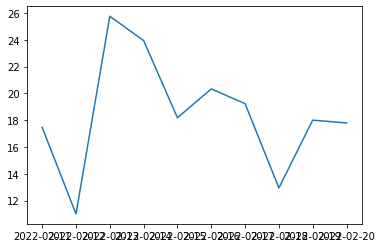

In [149]:
plt.plot(data['day'],data['prediction'])